# Vision | Deep Domain Confusion

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of the paper - [*Deep Domain Confusion: Maximizing for Domain Invariance*](https://arxiv.org/pdf/1412.3474.pdf) using PyTorch.

First we'll train the a model on source dataset => MNIST. Then we'll compare it's performance on the target => MNISTM. Then we'll train another model using domain adaptation and test it again on MNISTM. 

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

## Define Paths and Set GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

# root_dir = "../../../data/computer_vision/domain_adaptation/Mnist2MnistM/"
root_dir = "../data/Mnist2MnistM/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => ../data/Mnist2MnistM/


In [5]:
os.listdir(root_dir)

['mnist', 'mnistM']

## Load MNIST and MNIST-M Data

In [6]:
mnist_dir = root_dir + "mnist/"
mnist_m_dir = root_dir + "mnistM/"

### Preprocess Images

The MNIST-M images are 32x32 while the MNIST images are 28x28. We will resize all images to 28x28 and convert them to tensor. We will also Normalize our images. 

In [7]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ]),
    "test": transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
    ])
}

### Create Train and Test Datasets

In [8]:
# mnist
mnist_dataset_train = datasets.ImageFolder(root = mnist_dir + "train",
                                           transform = image_transforms["train"]
                                          )

mnist_dataset_test = datasets.ImageFolder(root = mnist_dir + "test",
                                           transform = image_transforms["test"]
                                          )


# mnistM
mnist_m_dataset_train_val = datasets.ImageFolder(root = mnist_m_dir + "train",
                                             transform = image_transforms["train"]
                                            )

mnist_m_dataset_test = datasets.ImageFolder(root = mnist_m_dir + "test",
                                            transform = image_transforms["test"]
                                           )

### Create [Train+Validation] Data from Train Set

We will create a validation out of MNIST-M only. So, DANN will train data using both MNIST and MNIST-M and then we'll use DANN to evaluate our validation data which will consist of only MNIST-M.

In [9]:
mnist_m_targets = mnist_m_dataset_train_val.targets

mnist_m_train_idx, mnist_m_val_idx = train_test_split(np.arange(len(mnist_m_targets)), test_size = 0.2, shuffle=True, stratify=mnist_m_targets)

In [10]:
mnist_m_train_sampler = torch.utils.data.SubsetRandomSampler(mnist_m_train_idx)
mnist_m_val_sampler = torch.utils.data.SubsetRandomSampler(mnist_m_val_idx)

### Create Dataloader

In [11]:
BATCH_SIZE = 64

# mnist
mnist_loader_train = torch.utils.data.DataLoader(mnist_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_loader_test = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=False)

# mnistM
mnist_m_loader_train = torch.utils.data.DataLoader(mnist_m_dataset_train_val, batch_size=BATCH_SIZE, sampler=mnist_m_train_sampler)
mnist_m_loader_val = torch.utils.data.DataLoader(mnist_m_dataset_train_val, batch_size=1, sampler=mnist_m_val_sampler)
mnist_m_loader_test = torch.utils.data.DataLoader(mnist_m_dataset_test, batch_size=1, shuffle=False)

### Explore Data

#### Create ID <=> Class Mapping

In [12]:
mnist_dataset_train.class_to_idx

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [13]:
idx2class = {v: k for k, v in mnist_dataset_train.class_to_idx.items()}
idx2class

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

#### Observe Class Distribution

In [14]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        count_dict[str(y_lbl)] += 1
            
    return count_dict

In [15]:
print("MNIST Train", get_class_distribution(mnist_dataset_train))
print("MNIST Test", get_class_distribution(mnist_dataset_test))

print("MNIST-M Train", get_class_distribution(mnist_m_dataset_train_val))
print("MNIST-M Test", get_class_distribution(mnist_m_dataset_test))

MNIST Train {'0': 5923, '1': 6742, '2': 5958, '3': 6131, '4': 5842, '5': 5421, '6': 5918, '7': 6265, '8': 5851, '9': 5949}
MNIST Test {'0': 980, '1': 1135, '2': 1032, '3': 1010, '4': 982, '5': 892, '6': 958, '7': 1028, '8': 974, '9': 1009}
MNIST-M Train {'0': 5825, '1': 6640, '2': 5853, '3': 6028, '4': 5746, '5': 5331, '6': 5812, '7': 6158, '8': 5757, '9': 5851}
MNIST-M Test {'0': 878, '1': 1016, '2': 933, '3': 908, '4': 890, '5': 807, '6': 856, '7': 914, '8': 880, '9': 919}


Text(0.5, 1.0, '[Target]MNIST-M Distribution in Test Set')

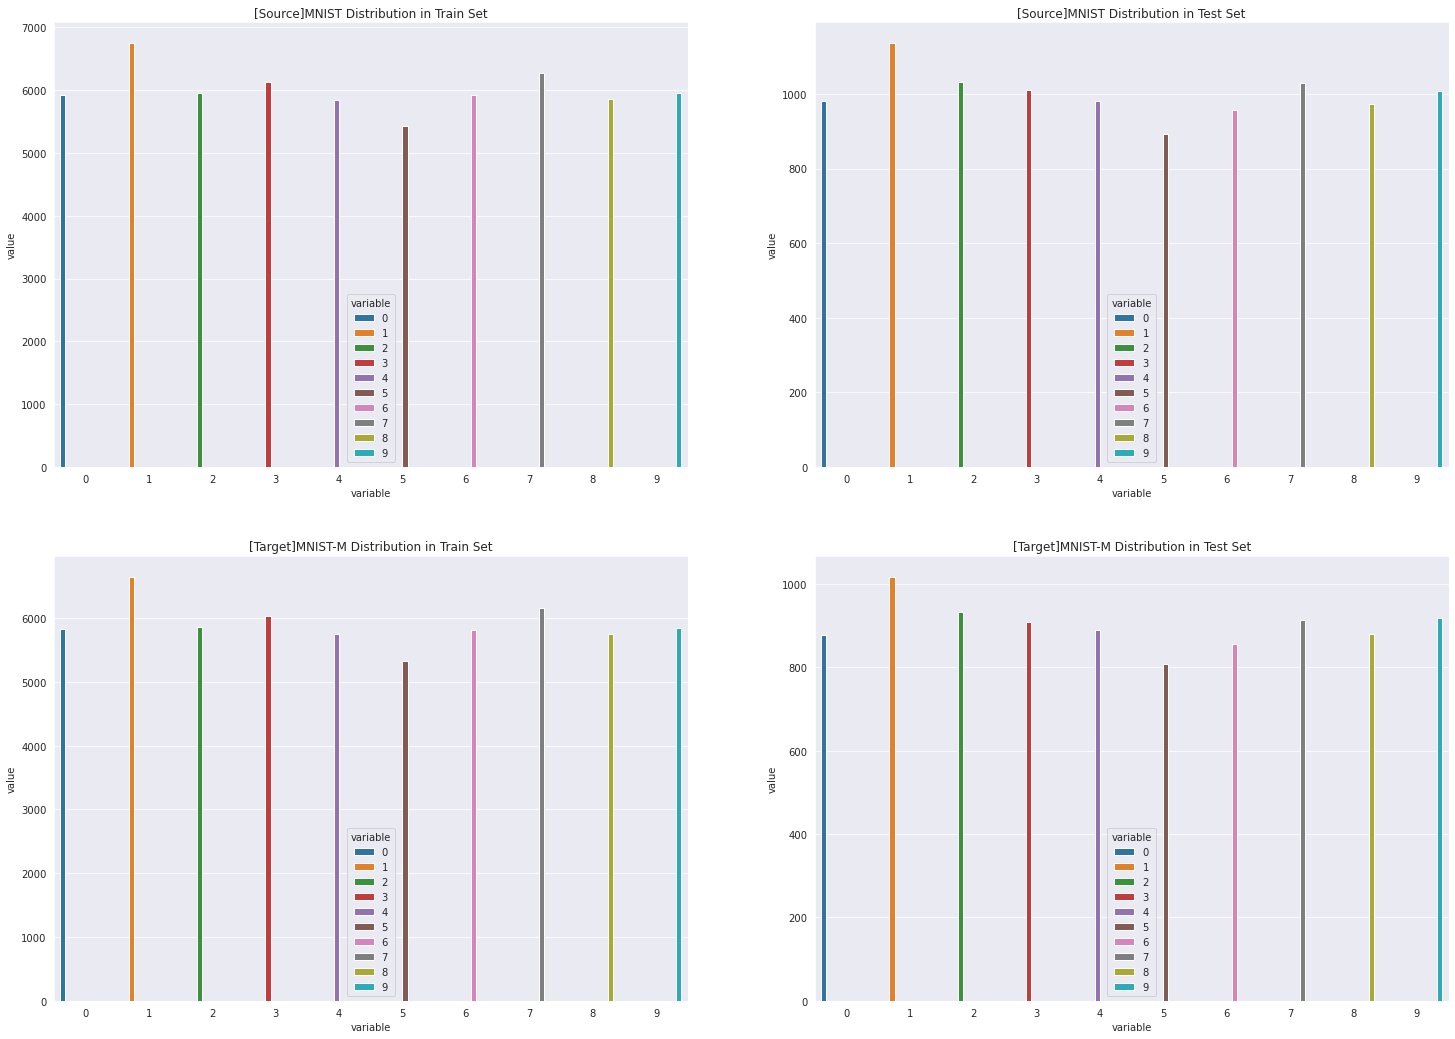

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,18))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_dataset_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0, 0]).set_title('[Source]MNIST Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_dataset_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0, 1]).set_title('[Source]MNIST Distribution in Test Set')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_m_dataset_train_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1, 0]).set_title('[Target]MNIST-M Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(mnist_m_dataset_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1, 1]).set_title('[Target]MNIST-M Distribution in Test Set')

#### MNIST

In [17]:
single_batch = next(iter(mnist_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([64, 3, 28, 28])
Output labels:  torch.Size([64])


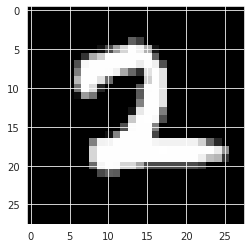

In [18]:
plt.imshow(images[0].permute(1, 2, 0))

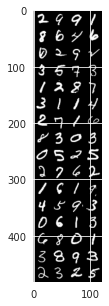

In [19]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

#### MNIST-M

In [20]:
single_batch = next(iter(mnist_m_loader_train))
images, labels = single_batch

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([64, 3, 28, 28])
Output labels:  torch.Size([64])


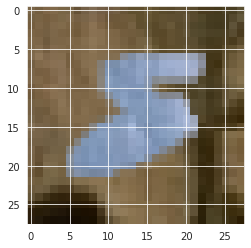

In [21]:
plt.imshow(images[0].permute(1, 2, 0))

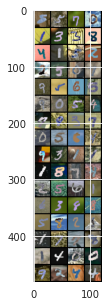

In [22]:
single_image = single_batch[0][0]
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,5))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Function to calculate Accuracy

In [23]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags.squeeze() == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

## TRAIN on MNIST [Source]

### Model Definition

In [24]:
class ModelMnistSource(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelMnistSource, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.1)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2)
        )
        
        self.fc = nn.Linear(32*28*28, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### Initialize Model

In [25]:
model_mnist = ModelMnistSource()
print(f"We're using {device}.\n")
model_mnist.to(device)
print(model_mnist)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

We're using cuda.

ModelMnistSource(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=25088, out_features=10, bias=True)
)


### Train Loop

In [26]:
EPOCHS = 3

print("Training has started.\n")
for e in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model_mnist.train()
    for X_train_batch, y_train_batch in mnist_loader_train:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model_mnist(X_train_batch).squeeze()
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(mnist_loader_train):.5f} | Train Acc: {train_epoch_acc/len(mnist_loader_train):.3f}')

Training has started.



Epoch 001: | Train Loss: 0.33159 | Train Acc: 99.041
Epoch 002: | Train Loss: 0.09622 | Train Acc: 100.000
Epoch 003: | Train Loss: 0.07334 | Train Acc: 100.000



## Test on MNIST [Source]

In [27]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        

y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [28]:
print("Trained on MNIST | Tested on MNIST. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST. 


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Test on MNIST-M [Target]

Now, let's test our model on the target dataset, ie. MNIST-M.

To do that, we need to load the data first.

In [29]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    model_mnist.eval()
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_test_pred = model_mnist(x_batch)
        
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())
        
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [30]:
print("Trained on MNIST | Tested on MNIST-M. \n\n")
print(classification_report(y_true_list, y_pred_list))

Trained on MNIST | Tested on MNIST-M. 


              precision    recall  f1-score   support

           0       0.94      0.33      0.49       878
           1       0.97      0.25      0.40      1016
           2       0.16      0.92      0.27       933
           3       0.43      0.54      0.48       908
           4       0.99      0.18      0.31       890
           5       0.99      0.18      0.31       807
           6       0.92      0.36      0.52       856
           7       0.88      0.33      0.48       914
           8       0.71      0.34      0.46       880
           9       0.66      0.39      0.49       919

    accuracy                           0.39      9001
   macro avg       0.77      0.38      0.42      9001
weighted avg       0.76      0.39      0.42      9001



**As we see from the results above, our model trained on MNIST performs horribly for MNIST-M.**

> Let's see some of that unsupervised domain adaption now.

## Train DDC Model [using MNIST and MNIST-M]

In a DDC, we use both MNIST and MNIST-M ie. source and target to train our model.

![deep_domain_confusion.png](../../../assets/deep_domain_confusion.png)

### Model Definition

In [31]:
class ModelDDC(nn.Module):
    def __init__(self, num_domains, num_classes):
        super(ModelDDC, self).__init__()
        
        self.num_domains = num_domains
        self.num_classes = num_classes
        
        
        self.feature_extractor = nn.Sequential(
            # conv 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # conv 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            # conv 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        self.adapt_source = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.adapt_target = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.fc8 = nn.Conv2d(in_channels=64, out_channels=self.num_classes, kernel_size=28, stride=1, padding=0)
        
        self.relu = nn.ReLU()
        
    def forward(self, x_source, x_target, is_train):
        if is_train:
            x_source = self.feature_extractor(x_source)
            x_target = self.feature_extractor(x_target)

            source_bottleneck = self.relu(self.adapt_source(x_source))
            target_bottleneck = self.relu(self.adapt_target(x_target))

            source_pred = self.fc8(source_bottleneck)

            return source_pred, source_bottleneck, target_bottleneck
        else:
            x_source = self.feature_extractor(x_source)

            source_bottleneck = self.relu(self.adapt_source(x_source))

            source_pred = self.fc8(source_bottleneck)

            return source_pred
            

### Define MMD Loss

In [32]:
def mmd_loss(x_source, y_source):
    delta = x_source - y_source
    loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))
    
    return loss

### Initialize Model

In [33]:
model_ddc = ModelDDC(num_domains = 2, num_classes = 10)

model_ddc.to(device)

print(model_ddc)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ddc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

ModelDDC(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (adapt_source): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adapt_target): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc8): Conv2d(64, 10, kernel_size=(28, 28), stride=(1, 1))
  (relu): ReLU()
)


### Model Output Example

In [34]:
x_source_example, y_source_example = next(iter(mnist_loader_train))
x_target_example, y_target_example = next(iter(mnist_m_loader_train))

In [35]:
print("Source input shapes: ", "\n\tX - ", x_source_example.shape, "\n\ty - ",y_source_example.shape)
print("Target input shapes: ", "\n\tX - ", x_target_example.shape, "\n\ty - ",y_target_example.shape)

Source input shapes:  
	X -  torch.Size([64, 3, 28, 28]) 
	y -  torch.Size([64])
Target input shapes:  
	X -  torch.Size([64, 3, 28, 28]) 
	y -  torch.Size([64])


In [36]:
source_pred, source_bottleneck, target_bottleneck = model_ddc(x_source_example.to(device), x_target_example.to(device), is_train=True)
print("Shape of class predictor = ", source_pred.shape)
print("Shape of source bottleneck = ", source_bottleneck.shape)
print("Shape of target bottleneck: ", target_bottleneck.shape)
print("Example MMD calculation = ", mmd_loss(source_bottleneck.view(BATCH_SIZE, -1), target_bottleneck.view(BATCH_SIZE, -1)).item())

Shape of class predictor =  torch.Size([64, 10, 1, 1])
Shape of source bottleneck =  torch.Size([64, 64, 28, 28])
Shape of target bottleneck:  torch.Size([64, 64, 28, 28])
Example MMD calculation =  25.821266174316406


### Training Loop

#### The Problem of Number of Batches

We need to do one last thing before we start training. The two datasets (source and target) might have different sizes and as a result, different number of batches. We need to obtain the minimum of the two _number of batches_ between the source and target dataloaders.

In [37]:
MAX_BATCH_NUM = min(len(mnist_loader_train), len(mnist_m_loader_train)) - 1
MAX_BATCH_NUM

737

In [38]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

Since, everything is working as expected, let's proceed to writing the training loop.

In [39]:
EPOCHS = 25

In [40]:
for e in tqdm(range(1, EPOCHS+1)):
    
    train_loader_source = iter(mnist_loader_train)
    train_loader_target = iter(mnist_m_loader_train)
    val_loader_target = mnist_m_loader_val

    # TRAINING
    model_ddc.train()
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    lmbda = 2 / (1 + math.exp(-10 * (e) / 1000)) - 1
    
    for b in range(MAX_BATCH_NUM):
        
        x_train_source, y_train_source = next(train_loader_source)
        x_train_target, y_train_target = next(train_loader_target)
        
        x_train_source, y_train_source = x_train_source.to(device), y_train_source.to(device)
        x_train_target, y_train_target = x_train_target.to(device), y_train_target.to(device)
        
        
        optimizer.zero_grad()
        
        # forward prop
        y_pred_class_source, source_bottleneck, target_bottleneck = model_ddc(x_train_source, x_train_target, is_train = True)
        
        # Cross Entropy Loss
        loss_class = criterion(y_pred_class_source.squeeze(), y_train_source)
        
        # MMD loss
        loss_mmd = mmd_loss(source_bottleneck.view(BATCH_SIZE, -1), target_bottleneck.view(BATCH_SIZE, -1))

        # calculate total-loss and class-accuracy for target
        total_loss = loss_class + (lmbda * loss_mmd)
        
        total_loss.backward()
        optimizer.step()
        
        train_epoch_loss += total_loss.item()
        
    with torch.no_grad():
        model_ddc.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        for x_val_target, y_val_target in val_loader_target:
            x_val_target, y_val_target = x_val_target.to(device), y_val_target.to(device)
            
            y_val_pred_class_source = model_ddc(x_val_target, _, is_train=False)
            
            val_epoch_loss += criterion(y_val_pred_class_source.squeeze().unsqueeze(0), y_val_target).item()
            val_epoch_acc += multi_acc(y_val_pred_class_source.squeeze().unsqueeze(0), y_val_target).item()
            

    loss_stats['train'].append(train_epoch_loss/MAX_BATCH_NUM)
    loss_stats['val'].append(val_epoch_loss/len(val_loader_target))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader_target))

    print(f'Epoch {e+0:02}: | Train Loss (Total): {train_epoch_loss/MAX_BATCH_NUM:.5f} | Val Loss(Target): {val_epoch_loss/len(val_loader_target):.2f} | Val Acc(Target): {val_epoch_acc/len(val_loader_target):.2f}')

Epoch 01: | Train Loss (Total): 1.13675 | Val Loss(Target): 2.18 | Val Acc(Target): 46.58
Epoch 02: | Train Loss (Total): 0.43602 | Val Loss(Target): 1.96 | Val Acc(Target): 50.04
Epoch 03: | Train Loss (Total): 0.32351 | Val Loss(Target): 1.65 | Val Acc(Target): 54.26
Epoch 04: | Train Loss (Total): 0.27369 | Val Loss(Target): 1.46 | Val Acc(Target): 57.22
Epoch 05: | Train Loss (Total): 0.24512 | Val Loss(Target): 1.48 | Val Acc(Target): 55.85
Epoch 06: | Train Loss (Total): 0.23078 | Val Loss(Target): 1.23 | Val Acc(Target): 61.94
Epoch 07: | Train Loss (Total): 0.21770 | Val Loss(Target): 1.26 | Val Acc(Target): 60.11
Epoch 08: | Train Loss (Total): 0.21112 | Val Loss(Target): 1.14 | Val Acc(Target): 63.79
Epoch 09: | Train Loss (Total): 0.20413 | Val Loss(Target): 1.24 | Val Acc(Target): 60.05
Epoch 10: | Train Loss (Total): 0.19731 | Val Loss(Target): 1.18 | Val Acc(Target): 62.41
Epoch 11: | Train Loss (Total): 0.19360 | Val Loss(Target): 1.26 | Val Acc(Target): 59.63
Epoch 12: 

## Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the `accuracy_stats` and `loss_stats` dictionaries.


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

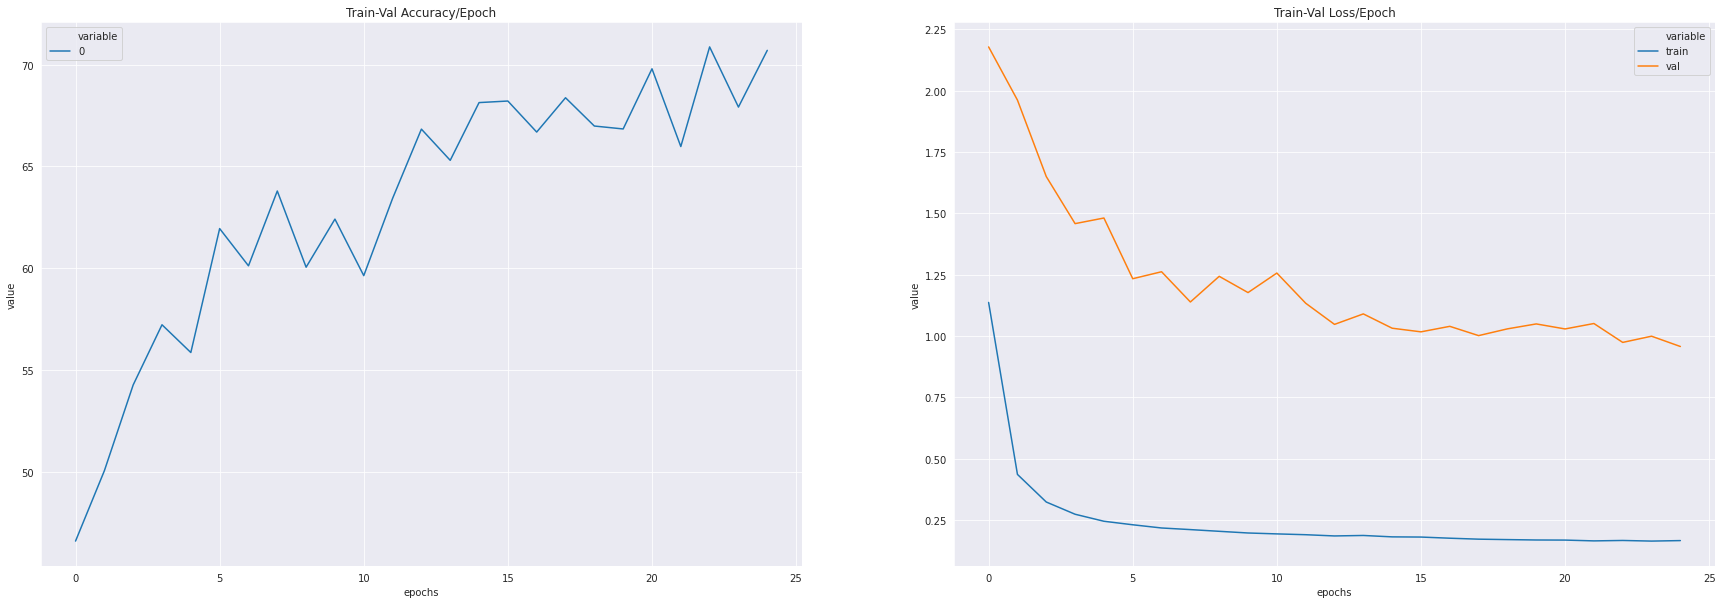

In [48]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats["val"]).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test DDC Model on Target [MNIST-M]

In [49]:
y_pred_class_list = []
y_true_class_list = []

with torch.no_grad():
    model_ddc.eval()
    
    for x_batch, y_batch in tqdm(mnist_m_loader_test):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        class_pred = model_ddc(x_batch, _, is_train=False)
        class_pred_logsoftmax = torch.log_softmax(class_pred, dim = 1)
        
        _, class_pred_value = torch.max(class_pred_logsoftmax, dim = 1)
        
        y_true_class_list.append(y_batch.item())
        y_pred_class_list.append(class_pred_value.item())

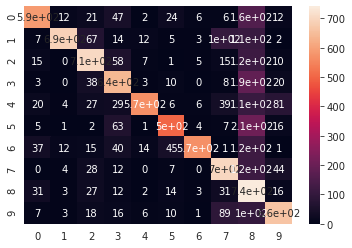

In [50]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_class_list, y_pred_class_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [51]:
print(classification_report(y_true_class_list, y_pred_class_list))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74       878
           1       0.95      0.68      0.79      1016
           2       0.74      0.76      0.75       933
           3       0.69      0.70      0.70       908
           4       0.92      0.64      0.75       890
           5       0.80      0.62      0.70       807
           6       0.95      0.67      0.79       856
           7       0.70      0.77      0.73       914
           8       0.38      0.84      0.52       880
           9       0.77      0.72      0.74       919

    accuracy                           0.71      9001
   macro avg       0.77      0.71      0.72      9001
weighted avg       0.77      0.71      0.72      9001

